 **IBM Virus Species Jump Hackathon at Deep Learning IndabaX 2019 in Durban**

Goal: Predict whether an unknown animal virus could potentially infect humans given its genome (DNA or RNA) sequence.

Importance:

Many old and new dangerous viruses infecting humans emerge from animals. Emergence of new viruses is currently considered one of the biggest existential threats facing humanity. In 1918, a world-wide flu outbreak killed over 50 million people around the world. Ebola virus is thought to have come from bats, HIV virus is thought to have come from monkeys, SARS virus potentially came from birds, and many more. We can today sequence thousands of viruses in animals but it is hard to identify which of the tens of thousands of viruses present in wild and domestic animals could potentially cross over to infect humans. Thus, a computational model to predict whether an animal virus can infect humans would be of huge importance.

Training Data: Genome sequences of 70 human viruses that can be easily transmitted from animals to humans, e.g. ebola (Class Label: Zoonotic) and sequences of another 70 viruses that cannot be easily transmitted from animals to humans (Class Label: Non-Zoonotic).

The genome sequences are basically a string of 4 characters (AGCT) and the sequence of each virus ranges from 2000 letters to 10,000 characters. If you feel the training/test dataset is small, an option is to fragment each virus genome into smaller pieces which could easily create a training set of 5,000 to 10,000 samples in each class (i.e we can fragment each viral genome into 100 pieces).

Test Data: 60 Genome sequences with the class label hidden from participants but provided to hackathon organizers (30 from each class).

Evaluation: Participants will have to provide a deep learning model and their predictions for each provided test sample. Evaluation will be based on the follwing two criteria:

    Most innovative model
    Performance based on AUC/ precision-recall curves

Let's get started. Import all the necessary Python libraries.

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import string
import re
#import matplotlib
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Load the data uploaded to the current Colab instance under /content/sample_data/

In [42]:
with open("NonZoonoticVirusesTrain.fasta") as f:
    NonZoo_raw_data  = f.read()
    
with open("ZoonoticVirusesTrain.fasta") as g:
    Zoo_raw_data  = g.read()
    
with open("VirusesTestInput.fasta") as h:
    test_raw_data  = h.read()

Preprocessing the data.

In [43]:
NonZoodata = NonZoo_raw_data.split(">")
Zoodata = Zoo_raw_data.split(">")
testdata = test_raw_data.split(">")

# dump the epmpy string in position [0]
NonZoodata2 = NonZoodata[1:]
Zoodata2 = Zoodata[1:]
testdata2 = testdata[1:]

Separate names and sequences into two lists.

In [44]:
NonZoo_new_data = [x.split(",") for x in NonZoodata2]
Zoo_new_data = [x.split(",") for x in Zoodata2]
test_new_data = [x.split(",") for x in testdata2]

NonZoo_id_name = []
Zoo_id_name = []
test_id_name = []
NonZoo_genome_sequence = []
Zoo_genome_sequence = []
test_genome_sequence = []

for x in NonZoo_new_data:
    NonZoo_id_name.append(x[0])
    NonZoo_genome_sequence.append(x[1])
    
for x in Zoo_new_data:
    Zoo_id_name.append(x[0])
    Zoo_genome_sequence.append(x[1])
    
for x in test_new_data:
    test_id_name.append(x[0])
    test_genome_sequence.append(x[1])

Separate into ID, Description and Sequence. From the data, you can just plit the ID using the first occurance of a "white space".

In [45]:
def clean_id_names(text):
    id_and_names = text.split(' ',1)
    return id_and_names

In [46]:
ZooID_Description = []
NonZooID_Description = []
testID_Description = []
for x in Zoo_id_name:
    ZooID_Description.append(clean_id_names(x))
for x in NonZoo_id_name:
    NonZooID_Description.append(clean_id_names(x)) 
for x in test_id_name:
    testID_Description.append(clean_id_names(x))

In [47]:
Zoo_ID = []
Zoo_Description = []

for x in ZooID_Description:
    Zoo_ID.append(x[0])
    Zoo_Description.append(x[1])
    
NonZoo_ID = []
NonZoo_Description = []

for x in NonZooID_Description:
    NonZoo_ID.append(x[0])
    NonZoo_Description.append(x[1])
    
test_ID = []
test_Description = []

for x in testID_Description:
    test_ID.append(x[0])
    test_Description.append(x[1])

Clean the sequences.

In [48]:
def clean_text(text):
    
    remove_lower = lambda text: re.sub('[a-z]', '', text)
    
    text = remove_lower(text)
    text = text.strip()
    text = text.replace('\n', '')
    return text

In [49]:
NonZoo_clean_sequences = []
Zoo_clean_sequences = []
test_clean_sequences = []
for seq in NonZoo_genome_sequence:
    NonZoo_clean_sequences.append(clean_text(seq))
    
for seq in Zoo_genome_sequence:
    Zoo_clean_sequences.append(clean_text(seq))
    
for seq in test_genome_sequence:
    test_clean_sequences.append(clean_text(seq))

Now we create two lists for classification, zeros and ones.

In [50]:
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

def onelistmaker(n):
    listofzeros = [1] * n
    return listofzeros

In [51]:
Zoolabels = zerolistmaker(len(Zoo_clean_sequences)) #Zootonic viruses as Class 0.
NonZoolabels = onelistmaker(len(NonZoo_clean_sequences)) #NonZootonic viruses as Class 1.

Now merge the data and the labels.

In [52]:
Zoo_data_frame = [list(x) for x in zip(Zoo_ID,Zoo_Description,Zoo_clean_sequences,Zoolabels)]
NonZoo_data_frame = [list(x) for x in zip(NonZoo_ID,NonZoo_Description,NonZoo_clean_sequences,NonZoolabels)]
test_data_frame = [list(x) for x in zip(test_ID,test_Description,test_clean_sequences)]
trainlist = Zoo_data_frame + NonZoo_data_frame
dataframe = pd.DataFrame(trainlist, columns = ['ID' , 'Description', 'Sequences', 'Labels'])
dataframe.head()

,ID,Description,Sequences,Labels
0,NC_003466.1,Andes virus segment S,TAGTAGTAGACTCCTTGAGAAGCTACTGCTGCGAAAGCTGGAATGA...,0
1,NC_003468.2,Andes virus segment L,TAGTAGTAGACTCCGGGATAGAAAAAGTTAGAAAAATGGAAAAGTA...,0
2,NC_003467.2,Andes virus segment M,TAGTAGTAGACTCCGCAAGAAGAAGCAAAAAATTAAAGAAGTGAGT...,0
3,NC_009026.2,Bussuquara virus,AGTATTTCTTCTGCGTGAGACCATTGCGACAGTTCGTACCGGTGAG...,0
4,NC_004211.1,Banna virus strain JKT-6423 segment 1,GTATTAAAAATTATCAACAAGGAATGGACATTCAAGAACAATTTGA...,0


In [53]:
testframe = pd.DataFrame(test_data_frame, columns = ['ID' , 'Description', 'Sequences'])
testframe.head()

,ID,Description,Sequences
0,NC_002728.1,Nipah virus,ACCAAACAAGGGAGAATATGGATACGTTAAAATATATAACGTATTT...
1,NC_005283.1,Dolphin morbillivirus,ACCAGACAAAGCTGGCTAGGGGTAGAATAACAGATAATGATAAATT...
2,NC_001498.1,Measles virus,ACCAAACAAAGTTGGGTAAGGATAGATCAATCAATGATCATATTCT...
3,NC_004148.2,Human metapneumovirus,ACGCGAAAAAAACGCGTATAAATTAAGTTACAAAAAAACATGGGAC...
4,NC_003266.2,Human adenovirus E,CATCATCAATAATATACCTTATTTTTTTTGTGTGAGTTAATATGCA...


In [54]:
# Check for any nulls values
print(dataframe.isnull().sum())
print(testframe.isnull().sum())

ID             0
Description    0
Sequences      0
Labels         0
dtype: int64
ID             0
Description    0
Sequences      0
dtype: int64


In [55]:
# remove unwanted features 
clean_data = dataframe.drop(['ID', 'Description'],1)
clean_data.reset_index(drop=True).head()

,Sequences,Labels
0,TAGTAGTAGACTCCTTGAGAAGCTACTGCTGCGAAAGCTGGAATGA...,0
1,TAGTAGTAGACTCCGGGATAGAAAAAGTTAGAAAAATGGAAAAGTA...,0
2,TAGTAGTAGACTCCGCAAGAAGAAGCAAAAAATTAAAGAAGTGAGT...,0
3,AGTATTTCTTCTGCGTGAGACCATTGCGACAGTTCGTACCGGTGAG...,0
4,GTATTAAAAATTATCAACAAGGAATGGACATTCAAGAACAATTTGA...,0


In [56]:
# remove unwanted features 
clean_test = testframe.drop(['ID', 'Description'],1)
clean_test.reset_index(drop=True).head()

,Sequences
0,ACCAAACAAGGGAGAATATGGATACGTTAAAATATATAACGTATTT...
1,ACCAGACAAAGCTGGCTAGGGGTAGAATAACAGATAATGATAAATT...
2,ACCAAACAAAGTTGGGTAAGGATAGATCAATCAATGATCATATTCT...
3,ACGCGAAAAAAACGCGTATAAATTAAGTTACAAAAAAACATGGGAC...
4,CATCATCAATAATATACCTTATTTTTTTTGTGTGAGTTAATATGCA...


# **This is where your model starts. Train your model on clean_data dataframe and predict classes for clean_test dataframe**

In [57]:
#clean_data.head() # Training data

# Expand data from current data
genomes_expanded = []
labels_expanded = []

def break_sequence(genome):
    N = len(genome)
    if N == 0:
        return ('','')
    STEP = 250
    genomes = []
    labels = []
    
    for i in range(0,N,STEP):
        genomes.append(genome[i:i+STEP])
    
    return genomes


clean_data['seq'] = [break_sequence(x) for x in clean_data['Sequences']]
    


# Create lookup map for sequences
def create_cartesian_seq(A,G,C,T):
    N = 256
    a = np.row_stack((A[0],G[0],C[0],T[0]))
    seq = np.chararray(shape=(N), unicode=True, itemsize=4)
    for i in range(4):
        for j in range(4):
            for k in range(4):
                for l in range(4): 
                    cnt = 64*(i) + 16*(j) + 4*(k) + (l)
                    seq[cnt] = str(a[i].tostring() + a[j].tostring() + a[k].tostring() + a[l].tostring())
    return seq

A = np.chararray((4,))
A[:] = 'A'
G = np.chararray((4,))
G[:] = 'G'
C = np.chararray((4,))
C[:] = 'C'
T = np.chararray((4,))
T[:] = 'T'

seq = create_cartesian_seq(A,G,C,T)
#print(seq)
#Break genomes up in to length 4

#len(clean_data.iloc[1,0])
#clean_data.head(10)

len(clean_data.loc[0,'seq'])

8

In [58]:
# Apply one-hot encoding on base pairs
def apply_encoding(genome, map_matrix):
    N = len(genome) #length of list
    max_len = 0
    
    #get longets string:
    for i in genome:
        if len(i) > max_len:
            max_len = len(i)
    
    STEP = 4 #SIZE OF GENOME SEQUENCE TO ENCODE
    
    a = np.chararray((1),itemsize=4) #temp array
    
    nrow = min(25,max(np.floor(max_len/STEP),25))
    ncol = map_matrix.shape[0]
    
    out_array = np.zeros(shape=(N,nrow,ncol))

    for j in range(N):
        string_len = len(genome[j])
        if string_len ==0 : #Compensate for error in data
            break
        for i in np.arange(0,string_len,STEP):
            if i >= 25:
                break
            a[0] = np.array(genome[j][i:i+STEP])
            out_array[j,i/4,:] = np.isin(seq,a).astype(float).round(2)
    return out_array

#apply_encoding(expanded_data.loc[1,'Sequences'],seq).shape

In [59]:
y_train = clean_data.loc[:,'Labels'].values.astype(float)
y_train = keras.utils.np_utils.to_categorical(y_train)

In [60]:
clean_data.head()

len(y_train)

140

In [61]:
# Build input matrix for Neural Net

clean_data['encodings'] = [apply_encoding(x,seq) for x in clean_data['seq']]

sum_1 = 0
for i in range(len(clean_data)):
    sum_1 += clean_data.loc[i,'encodings'].shape[1]
    
X_train = np.ndarray((len(clean_data),sum_1,25,256))

#clean_data.loc[1,'encodings'].shape
for i in range(len(clean_data)):
    for j in range(clean_data.loc[i,'encodings'].shape[0]):
        for v in range(clean_data.loc[i,'encodings'].shape[1]):
            X_train[i,j,:,:] = clean_data.loc[i,'encodings'][j]

In [62]:
#print('Y - rows : {} \nTotal of Positives : {}'.format(y.shape[0],np.sum(y, axis=0)))

#y
#print(len(clean_data))
#sum_1 = 0
#for i in range(len(clean_data)):
#    sum_1 += clean_data.loc[i,'encodings'].shape[1]

#print(sum_1)

#clean_data.loc[i,'encodings'].shape

X_train.shape

(140, 3500, 25, 256)

In [63]:
# Construct Deep Learning Network

from keras.models import Sequential, optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# Deep Convolutional Neural Network
model = Sequential()
# Input Layer - Convolution
model.add(Conv2D(50, (25,25),padding='same' ,activation='linear', input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.1))

# 2nd Layer
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
#3rd Layer
model.add(Dense(100,activation='sigmoid'))
#4th Layer
model.add(Dense(50,activation='sigmoid'))
# Output
model.add(Dense(2, activation='sigmoid'))

sgd = optimizers.Adam(lr=0.05, decay=1e-69)
model.compile(optimizer=sgd, loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
history = model.fit(X_train, y_train ,epochs=10, batch_size=4000, verbose=1, validation_split = 0.3)

Instructions for updating:
Use tf.cast instead.
Train on 98 samples, validate on 42 samples
Epoch 1/10


In [27]:
model.layers[0].output[:]

<tf.Tensor 'strided_slice:0' shape=(?, 25, 1000) dtype=float32>

<Figure size 432x288 with 0 Axes>

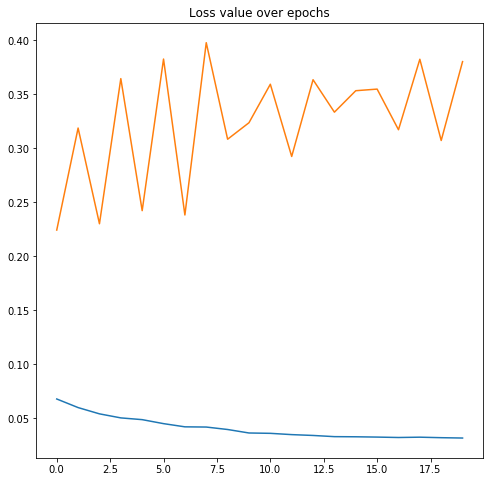

In [151]:
plt.clf()
plt.figure(figsize=(8,8))
plt.title('Loss value over epochs')
plt.plot(history.history['loss'], c='tab:blue')
plt.plot(history.history['val_loss'], c='tab:orange')
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

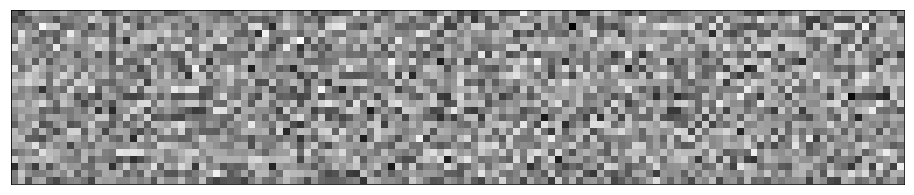

In [152]:
# Inspect activations
from keras import models
nodes = [node.output for node in model.layers[:10]]

activation_model = models.Model(inputs=model.inputs, outputs=nodes)
x = np.expand_dims(X[1,:,:], axis=0)
activation = activation_model.predict(x)

#activation[0][0,:].shape

plt.clf()
plt.figure(figsize=(8,8))
plt.matshow(np.reshape(activation[0][0,:], newshape=(25,128)), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.show()

In [108]:
activation[0][0].shape

(25, 128)

In [160]:
clean_test.head()

,Sequences
0,ACCAAACAAGGGAGAATATGGATACGTTAAAATATATAACGTATTT...
1,ACCAGACAAAGCTGGCTAGGGGTAGAATAACAGATAATGATAAATT...
2,ACCAAACAAAGTTGGGTAAGGATAGATCAATCAATGATCATATTCT...
3,ACGCGAAAAAAACGCGTATAAATTAAGTTACAAAAAAACATGGGAC...
4,CATCATCAATAATATACCTTATTTTTTTTGTGTGAGTTAATATGCA...


In [203]:
# Encode clean_test

clean_test['seq'] = [break_sequence(x) for x in clean_test['Sequences']]

sum_1 = 0
for i in range(len(clean_test)):
    sum_1 += clean_test.loc[i,'encodings'].shape[1]

X_train = np.ndarray((len(clean_test),sum_1,25,256))

clean_test['encodings'] = [apply_encoding(x,seq) for x in clean_test['seq']]

#clean_data.loc[1,'encodings'].shape
for i in range(len(clean_test)):
    for j in range(clean_test.loc[i,'encodings'].shape[0]):
        for v in range(clean_test.loc[i,'encodings'].shape[1]):
            X_train[i,j,:,:] = clean_test.loc[i,'encodings'][j]

IndexError: index 45 is out of bounds for axis 1 with size 45

# **Make predictions on test data and save to file for submission**

In [159]:
#import random
#y_pred_test = [random.randrange(0, 2, 1) for _ in range(60)] #Replace this with your predictions for the 60 input DNAs
y_pred_test = model.predict(X_test)

#np.sum(y_pred_test.round(),axis=0)


array([12263., 11372.], dtype=float32)

In [0]:
y_pred = [str(x) for x in y_pred_test]
pred_y = ","
pred_y = pred_y.join(y_pred)
with open("VirusesTestPrediction.fasta","w+") as o:
    o.write(pred_y)

{'A', 'B'}

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])